In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

##Import any other packages you may need here
import imageio
import pydicom


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5285,00028477_000.png,No Finding,0,28477,058Y,F,PA,2021,2021,0.194311,0.194311
4336,00021374_035.png,No Finding,35,21374,081Y,M,PA,2992,2991,0.143000,0.143000
1287,00006741_000.png,Effusion,0,6741,053Y,F,PA,2048,2500,0.168000,0.168000


In [4]:
## EDA
# map age to int
len(all_xray_df)

112120

### Missing values

In [5]:
# any missing values? => complete empty column
all_xray_df[all_xray_df.isna().any(axis=1)]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [6]:
# complete empty
all_xray_df['Unnamed: 11'].count()

0

In [7]:
all_xray_df = all_xray_df = all_xray_df.iloc[:,:11]

In [8]:
# no other missing values
all_xray_df[all_xray_df.isna().any(axis=1)]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]


### Demographics

In [9]:
# there seems to be some outliers
all_xray_df[all_xray_df['Patient Age'] > 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139


In [10]:
# remove outlier
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 100]

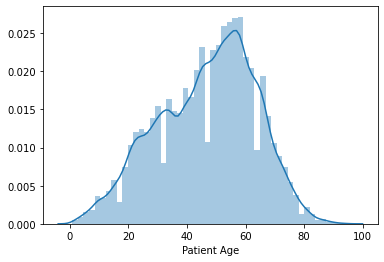

In [11]:
sns.distplot(all_xray_df['Patient Age'])

In [12]:
all_xray_df['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

In [13]:
all_xray_df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

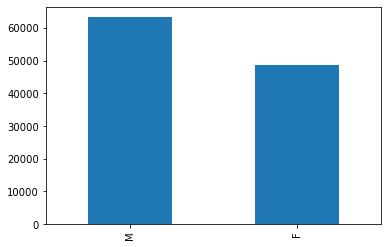

In [14]:
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

### Viewing Position

In [15]:
all_xray_df['View Position'].value_counts()

PA    67299
AP    44805
Name: View Position, dtype: int64

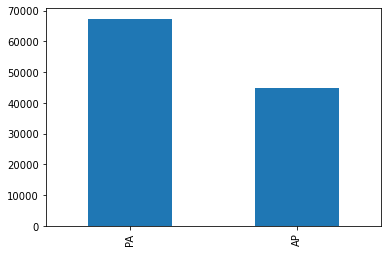

In [16]:
all_xray_df['View Position'].value_counts().plot(kind='bar')

### Number of cases 

In [17]:
all_xray_df['Finding Labels'].value_counts()

No Finding                                                   60353
Infiltration                                                  9546
Atelectasis                                                   4214
Effusion                                                      3955
Nodule                                                        2705
                                                             ...  
Atelectasis|Consolidation|Effusion|Emphysema|Pneumothorax        1
Infiltration|Effusion                                            1
Consolidation|Effusion|Mass|Nodule|Pneumothorax                  1
Edema|Effusion|Emphysema|Infiltration                            1
Infiltration|Mass|Nodule|Pneumonia                               1
Name: Finding Labels, Length: 836, dtype: int64

In [18]:
# split findings
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
38276,00010010_009.png,Effusion,9,10010,34,M,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533,00000127_004.png,Effusion,4,127,56,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95410,00025082_000.png,No Finding,0,25082,60,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
all_xray_df[all_labels].sum(axis=0)

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0
dtype: float64

In [20]:
# Number of pneumonia and non-pneumonia cases
all_xray_df.Pneumonia.value_counts()

0.0    110674
1.0      1430
Name: Pneumonia, dtype: int64

We have 62 pneumonia and 5543 non-pneumonia cases.

### Comorbid deseases

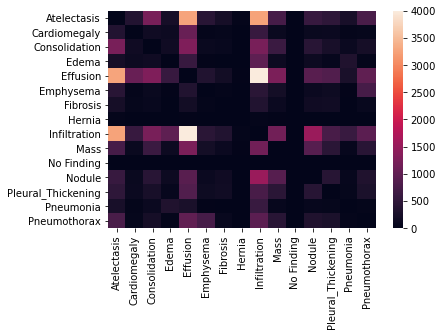

In [20]:
# general co-occurence
co_occurence = all_xray_df[all_labels].T.dot(all_xray_df[all_labels])
np.fill_diagonal(co_occurence.values,0)
sns.heatmap(co_occurence)

In [21]:
all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum(axis=0).sort_values()

No Finding               0.0
Hernia                   3.0
Fibrosis                11.0
Emphysema               23.0
Cardiomegaly            41.0
Pneumothorax            41.0
Pleural_Thickening      48.0
Nodule                  70.0
Mass                    71.0
Consolidation          123.0
Atelectasis            262.0
Effusion               268.0
Edema                  340.0
Infiltration           605.0
Pneumonia             1430.0
dtype: float64

Most frequent combination with pneumonia is infiltration, but also edema, effusion, atelectasis and consoloditation occur reasonably often at the same time.

### Number of disease per patient

In [22]:
all_xray_df[all_labels].sum(axis=1)

0         1.0
1         2.0
2         2.0
3         1.0
4         1.0
         ... 
112115    2.0
112116    1.0
112117    1.0
112118    1.0
112119    1.0
Length: 112104, dtype: float64

In [23]:
all_xray_df[all_labels].sum(axis=1).describe()

count    112104.000000
mean          1.262372
std           0.629874
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
dtype: float64

Text(0.5, 1.0, 'Number of disease per patient')

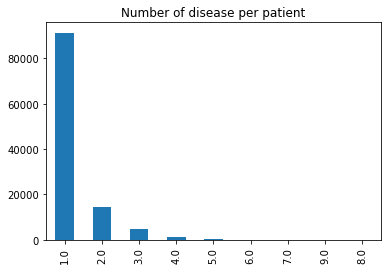

In [24]:
all_xray_df[all_labels].sum(axis=1).value_counts().plot(kind='bar')
plt.title('Number of disease per patient')

### Imaging data 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.
* use `sample_labels.csv` for the pixel-level assassements. 

In [25]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [26]:
len(sample_df)

5606

In [27]:
# map patient age to number
sample_df['Patient Age'] = sample_df['Patient Age'].map(lambda x: x[:len(x)-1]).astype(int)
# remove age outlier
sample_df = sample_df[sample_df['Patient Age'] < 100]

In [28]:
# split findings
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [29]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])

Scans found: 112120 , Total Headers 5605


In [30]:
# example image
im = imageio.imread(all_image_paths['00000013_005.png'])
print(im.shape)

(1024, 1024)


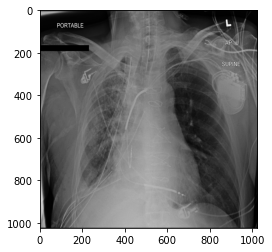

In [31]:
plt.imshow(im,cmap='gray')

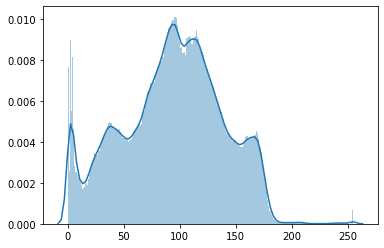

In [32]:
sns.distplot(im.ravel(), bins = 256)

In [50]:
def normalize(img):
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    img_norm = (img - mean_intensity)/std_intensity
    return img_norm



In [51]:
def plot_and_hist(image_path, x_start = 0, y_start = 0, width = 1024, height = 1024 ):
    im = imageio.imread(all_image_paths[image_path])[x_start:(x_start + width), y_start:(y_start+height)]
    im = normalize(im)
    plt.figure()
    plt.imshow(im,cmap='gray')
    plt.figure()
    sns.distplot(im.ravel())

#### Compare pneumonia cases and healthy cases

In [52]:
pneumonia_images = sample_df[sample_df.Pneumonia==1].sample(2)['Image Index'].values

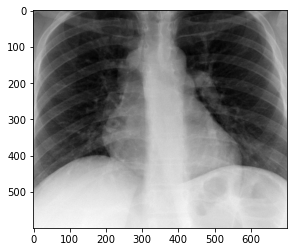

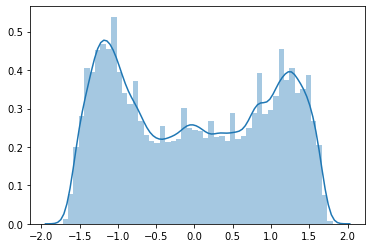

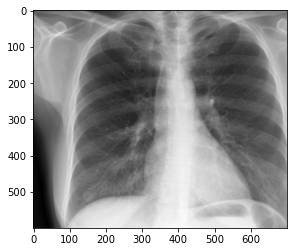

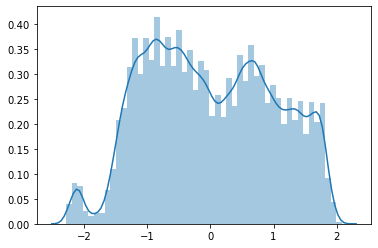

In [53]:
for img_path in pneumonia_images:
    plot_and_hist(img_path,150,150,600,700)

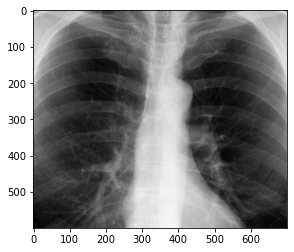

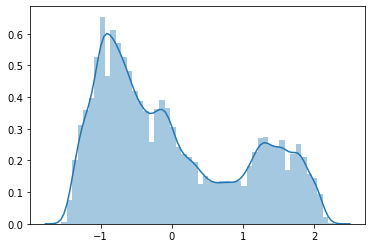

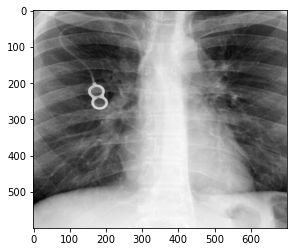

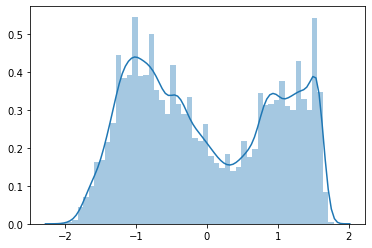

In [54]:
healthy_images = sample_df[sample_df['No Finding']==1].sample(2)['Image Index'].values
for img_path in healthy_images:
    plot_and_hist(img_path,150,150,600,700)

Its quite difficult to distinguish only based on density. 

#### Compare to other deseases

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0

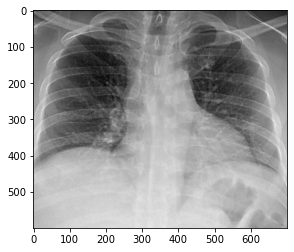

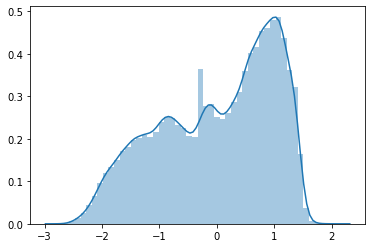

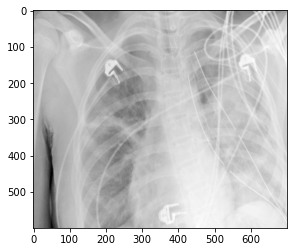

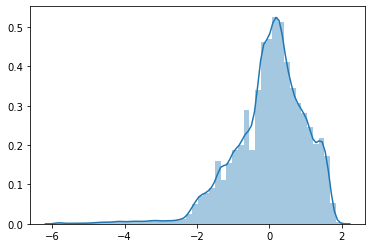

In [56]:
atelectasis_images = sample_df[sample_df.Atelectasis==1].sample(2)['Image Index'].values
for img_path in atelectasis_images:
    plot_and_hist(img_path,150,150,600,700)

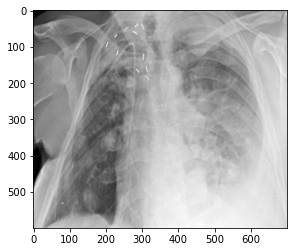

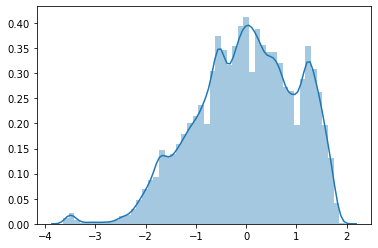

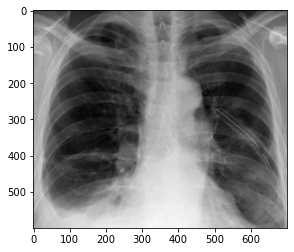

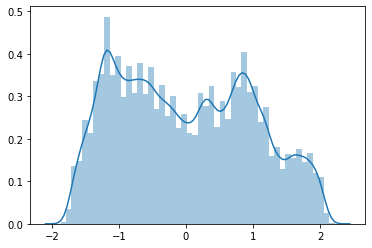

In [57]:
effusion_images = sample_df[sample_df.Effusion==1].sample(2)['Image Index'].values
for img_path in effusion_images:
    plot_and_hist(img_path,150,150,600,700)

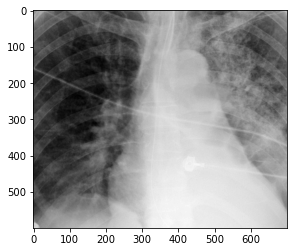

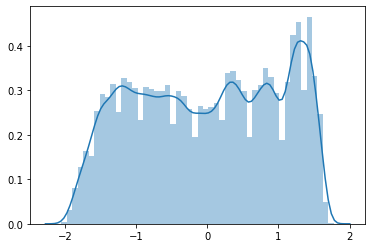

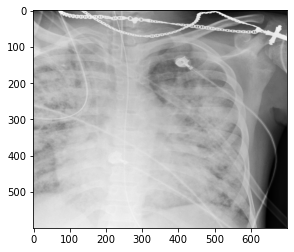

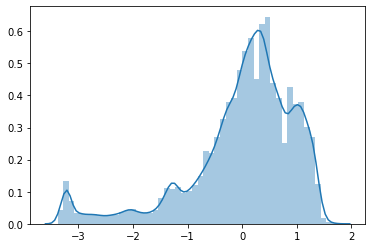

In [58]:
consolidation_images = sample_df[sample_df.Consolidation==1].sample(2)['Image Index'].values
for img_path in consolidation_images:
    plot_and_hist(img_path,150,150,600,700)

Its hard to distinguish different conditions based on the density distribution alone.